In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

Initializing sufficient statistics s_i...
Computing initial global sufficient statistics µ...

Computing final GMM parameters...


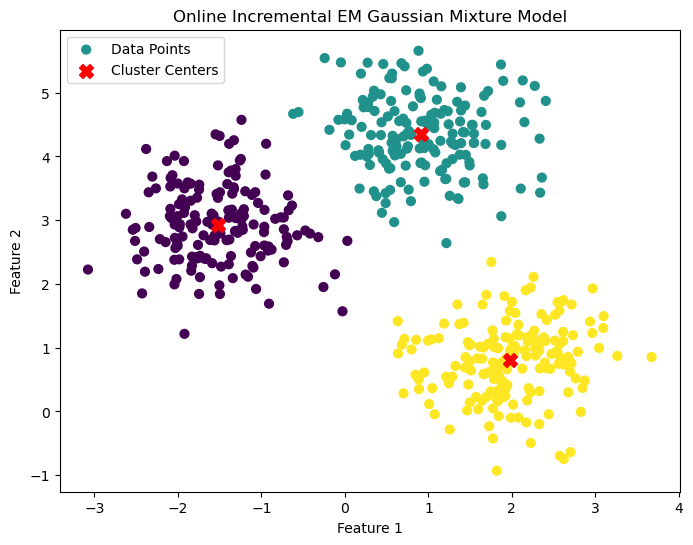

In [ ]:
# def initialize_s_i(X, n_components, random_state=None):
#     """
#     Initialize the sufficient statistics s_i for each data point.
    
#     Parameters:
#     - X: np.ndarray, shape (n_samples, n_features)
#         The input data.
#     - n_components: int
#         Number of Gaussian components.
#     - random_state: int or None
#         Seed for random number generator.
    
#     Returns:
#     - gamma: np.ndarray, shape (n_samples, n_components)
#         Responsibilities for each data point and component.
#     - gamma_x: np.ndarray, shape (n_samples, n_components, n_features)
#         Weighted data for each data point and component.
#     - gamma_xx: np.ndarray, shape (n_samples, n_components, n_features, n_features)
#         Weighted outer products for each data point and component.
#     """
#     n_samples, n_features = X.shape
#     if random_state is not None:
#         np.random.seed(random_state)
    
#     # Initialize responsibilities randomly and normalize
#     gamma = np.random.rand(n_samples, n_components)
#     gamma /= gamma.sum(axis=1, keepdims=True)  # Normalize to sum to 1
    
#     # Compute gamma * x_i
#     gamma_x = gamma[:, :, np.newaxis] * X[:, np.newaxis, :]  # Shape: (n_samples, K, d)
    
#     # Compute gamma * x_i * x_i^T
#     gamma_xx = np.empty((n_samples, n_components, n_features, n_features))
#     for i in range(n_samples):
#         for k in range(n_components):
#             x = X[i]
#             gamma_xx[i, k] = gamma[i, k] * np.outer(x, x)
    
#     return gamma, gamma_x, gamma_xx


# def compute_mu(gamma, gamma_x, gamma_xx, n_components, n_features):
#     """
#     Compute the global sufficient statistics µ from s_i.
    
#     Parameters:
#     - gamma: np.ndarray, shape (n_samples, n_components)
#         Responsibilities for each data point and component.
#     - gamma_x: np.ndarray, shape (n_samples, n_components, n_features)
#         Weighted data for each data point and component.
#     - gamma_xx: np.ndarray, shape (n_samples, n_components, n_features, n_features)
#         Weighted outer products for each data point and component.
#     - n_components: int
#         Number of Gaussian components.
#     - n_features: int
#         Number of features.
    
#     Returns:
#     - mu: dict
#         Contains N (sum of responsibilities), sum_x, and sum_xx for each component.
#     """
#     N = gamma.sum(axis=0)  # Shape: (K,)
#     sum_x = gamma_x.sum(axis=0)  # Shape: (K, d)
#     sum_xx = gamma_xx.sum(axis=0)  # Shape: (K, d, d)
#     mu = {'N': N, 'sum_x': sum_x, 'sum_xx': sum_xx}
#     return mu


# def compute_parameters(mu, n_samples):
#     """
#     Compute the GMM parameters from global sufficient statistics.
    
#     Parameters:
#     - mu: dict
#         Contains N, sum_x, and sum_xx for each component.
#     - n_samples: int
#         Total number of data points.
    
#     Returns:
#     - pi: np.ndarray, shape (K,)
#         Mixture coefficients for each component.
#     - mu_k: np.ndarray, shape (K, d)
#         Means for each component.
#     - sigma_k: np.ndarray, shape (K, d, d)
#         Covariance matrices for each component.
#     """
#     K = len(mu['N'])
#     pi = mu['N'] / n_samples  # Shape: (K,)
#     mu_k = mu['sum_x'] / mu['N'][:, np.newaxis]  # Shape: (K, d)
#     n_features = mu['sum_x'].shape[1]
    
#     sigma_k = np.empty((K, n_features, n_features))
#     for k in range(K):
#         sigma_k[k] = mu['sum_xx'][k] / mu['N'][k] - np.outer(mu_k[k], mu_k[k])
#         # Regularization to ensure positive-definite covariance matrices
#         sigma_k[k] += np.eye(n_features) * 1e-6
    
#     return pi, mu_k, sigma_k


# def compute_responsibilities(x_i, pi, mu_k, sigma_k):
#     """
#     Compute the responsibilities p(z | x_i; θ) for a single data point.
    
#     Parameters:
#     - x_i: np.ndarray, shape (d,)
#         The data point.
#     - pi: np.ndarray, shape (K,)
#         Mixture coefficients for each component.
#     - mu_k: np.ndarray, shape (K, d)
#         Means for each component.
#     - sigma_k: np.ndarray, shape (K, d, d)
#         Covariance matrices for each component.
    
#     Returns:
#     - gamma_prime: np.ndarray, shape (K,)
#         Updated responsibilities for the data point.
#     """
#     K = len(pi)
#     probs = np.zeros(K)
#     for k in range(K):
#         try:
#             probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
#         except np.linalg.LinAlgError:
#             # Handle singular covariance matrix
#             probs[k] = 0
#     if probs.sum() == 0:
#         # Assign equal responsibilities if sum is zero to avoid division by zero
#         gamma_prime = np.ones(K) / K
#     else:
#         gamma_prime = probs / probs.sum()
#     return gamma_prime  # Shape: (K,)


# def online_incremental_em_gmm(X, n_components=3, T=10, random_state=None):
#     """
#     Perform Online Incremental EM for Gaussian Mixture Models.
    
#     Parameters:
#     - X: np.ndarray, shape (n_samples, n_features)
#         The input data.
#     - n_components: int
#         Number of Gaussian components.
#     - T: int
#         Number of iterations.
#     - random_state: int or None
#         Seed for random number generator.
    
#     Returns:
#     - pi: np.ndarray, shape (K,)
#         Mixture coefficients for each component.
#     - mu_k: np.ndarray, shape (K, d)
#         Means for each component.
#     - sigma_k: np.ndarray, shape (K, d, d)
#         Covariance matrices for each component.
#     """
#     n_samples, n_features = X.shape
#     K = n_components
    
#     # Initialize sufficient statistics
#     print("Initializing sufficient statistics s_i...")
#     gamma, gamma_x, gamma_xx = initialize_s_i(X, K, random_state=random_state)
    
#     # Compute initial global sufficient statistics µ
#     print("Computing initial global sufficient statistics µ...")
#     mu = compute_mu(gamma, gamma_x, gamma_xx, K, n_features)
    
#     # Iterative updates
#     for t in range(T):
#         # print(f"\nStarting iteration {t+1}/{T}...")
#         # Shuffle data points
#         indices = np.arange(n_samples)
#         np.random.shuffle(indices)
        
#         for idx in indices:
#             x_i = X[idx]
            
#             # Compute current parameters from µ
#             pi, mu_k, sigma_k = compute_parameters(mu, n_samples)
            
#             # E-step: Compute responsibilities for x_i
#             gamma_prime = compute_responsibilities(x_i, pi, mu_k, sigma_k)  # Shape: (K,)
            
#             # Compute s'_i
#             s_prime_i_gamma = gamma_prime  # Shape: (K,)
#             s_prime_i_gamma_x = gamma_prime[:, np.newaxis] * x_i  # Shape: (K, d)
#             s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(K)])  # Shape: (K, d, d)
            
#             # Update global sufficient statistics µ
#             mu['N'] += s_prime_i_gamma - gamma[idx]  # Shape: (K,)
#             mu['sum_x'] += s_prime_i_gamma_x - gamma_x[idx]  # Shape: (K, d)
#             mu['sum_xx'] += s_prime_i_gamma_xx - gamma_xx[idx]  # Shape: (K, d, d)
            
#             # Update s_i for data point idx
#             gamma[idx] = s_prime_i_gamma
#             gamma_x[idx] = s_prime_i_gamma_x
#             gamma_xx[idx] = s_prime_i_gamma_xx
        
#         # print(f"Iteration {t+1} completed.")
    
#     # After all iterations, compute final parameters
#     print("\nComputing final GMM parameters...")
#     pi, mu_k, sigma_k = compute_parameters(mu, n_samples)
    
#     return pi, mu_k, sigma_k


# if __name__ == "__main__":
#     # 1. Generate synthetic data
#     X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=0)
    
#     # 2. Set parameters
#     n_components = 3
#     T = 25  # Number of iterations
#     random_state = 42
    
#     # 3. Run Online Incremental EM
#     pi, mu_k, sigma_k = online_incremental_em_gmm(X, n_components=n_components, T=T, random_state=random_state)
    
#     # 4. Assign clusters based on final responsibilities
#     K = n_components
#     labels = np.zeros(X.shape[0], dtype=int)
#     for i in range(X.shape[0]):
#         x_i = X[i]
#         probs = compute_responsibilities(x_i, pi, mu_k, sigma_k)
#         labels[i] = np.argmax(probs)
    
#     # 5. Plot the results
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', label='Data Points')
#     plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
#     plt.title('Online Incremental EM Gaussian Mixture Model')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.legend()
#     plt.show()



Computing final GMM parameters...


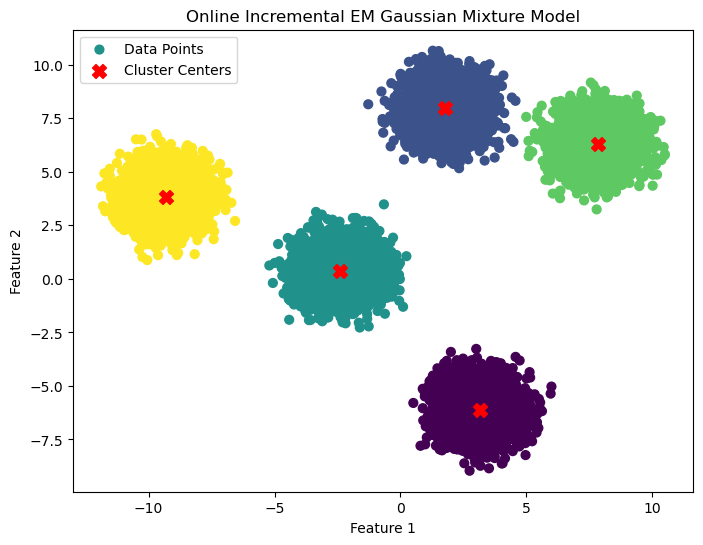

In [13]:
# def random_initialization(n_components, n_features, random_state=None):
#     np.random.seed(random_state)
    
#     # Random initialization of pi, means, and covariance matrices
#     pi = np.random.dirichlet(alpha=np.ones(n_components))
#     mu = np.random.randn(n_components, n_features) * n_components  # Random means with larger spread
    
#     # Initialize covariance matrices to be positive semidefinite
#     sigma = []
#     for _ in range(n_components):
#         A = np.random.randn(n_features, n_features)
#         cov_matrix = np.dot(A, A.T)  # Creating a symmetric positive semidefinite matrix
#         sigma.append(cov_matrix)
#     sigma = np.array(sigma)
    
#     return pi, mu, sigma

def initialize_parameters(n_components, n_features, first_points=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize mixing coefficients
    pi = np.ones(n_components) / n_components
    
    # Initialize means with more spread
    if first_points is not None:
        # Use the first few points with larger noise
        mu_k = first_points + np.random.randn(n_components, n_features) * 2.0
    else:
        mu_k = np.random.randn(n_components, n_features) * 5.0
    
    # Initialize with larger covariances
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k) 
        for k in range(n_components)
    ])
    
    return pi, mu_k, sigma_k

def compute_responsibilities(x, pi, mu, sigma, eps=1e-15):
    K = len(pi)
    log_responsibilities = np.zeros(K)
    
    for k in range(K):
        diff = x - mu[k]
        
        # Add small constant to diagonal for numerical stability
        sigma_k = sigma[k] + eps * np.eye(sigma[k].shape[0])
        
        # Compute log probability in a numerically stable way
        log_det = np.log(np.linalg.det(sigma_k))
        inv_sigma = np.linalg.inv(sigma_k)
        exponent = -0.5 * np.dot(diff.T, np.dot(inv_sigma, diff))
        log_responsibilities[k] = np.log(pi[k]) + exponent - 0.5 * (log_det + len(x) * np.log(2 * np.pi))
    
    # Subtract maximum for numerical stability
    log_responsibilities -= np.max(log_responsibilities)
    responsibilities = np.exp(log_responsibilities)
    responsibilities /= np.sum(responsibilities)
    
    return responsibilities

# def compute_parameters(mu_stats, n_samples):
#     pi = mu_stats['N'] / n_samples
#     mu_k = mu_stats['sum_x'] / mu_stats['N'][:, None]
#     sigma_k = np.array([mu_stats['sum_xx'][k] / mu_stats['N'][k] - np.outer(mu_k[k], mu_k[k]) for k in range(len(pi))])
#     return pi, mu_k, sigma_k

def compute_parameters(mu_stats, n_samples, reg_covar=1e-6, eps=1e-10):
    # Compute mixing coefficients with minimum probability
    pi = np.maximum(mu_stats['N'], eps)
    # pi = pi / np.sum(pi)
    pi = pi / n_samples
    
    # Compute means with safety check
    safe_N = np.maximum(mu_stats['N'], eps)[:, None]
    mu = mu_stats['sum_x'] / safe_N
    
    # Compute covariances
    sigma = []
    for k in range(len(pi)):
        safe_N_k = max(mu_stats['N'][k], eps)
        cov = mu_stats['sum_xx'][k] / safe_N_k - np.outer(mu[k], mu[k])
        # Ensure symmetry
        cov = (cov + cov.T) / 2
        # Add regularization to diagonal
        cov.flat[::len(cov) + 1] += reg_covar
        # Ensure positive definiteness
        min_eig = np.min(np.linalg.eigvals(cov))
        if min_eig < 0:
            cov.flat[::len(cov) + 1] -= min_eig - eps
        sigma.append(cov)
    
    return pi, mu, np.array(sigma)

def online_incremental_em_gmm(X, n_components=3, T=10, random_state=None):
    n_samples, n_features = X.shape
    
    # Step 1: Random initialization
    pi, mu, sigma = initialize_parameters(n_components, n_features, random_state=random_state)
    
    # Step 2: Placeholder for sufficient statistics
    gamma = np.zeros((n_samples, n_components))
    gamma_x = np.zeros((n_samples, n_components, n_features))
    gamma_xx = np.zeros((n_samples, n_components, n_features, n_features))
    
    mu_stats = {'N': np.zeros(n_components),
                'sum_x': np.zeros((n_components, n_features)),
                'sum_xx': np.zeros((n_components, n_features, n_features))}
    
    # EM Iterations
    for t in range(T):
        for idx in range(n_samples):
            x_i = X[idx]
            gamma_prime = compute_responsibilities(x_i, pi, mu, sigma)
            
            # Update sufficient statistics for point idx
            s_prime_i_gamma = gamma_prime  # Shape: (K,)
            s_prime_i_gamma_x = gamma_prime[:, None] * x_i  # Shape: (K, d)
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(n_components)])  # Shape: (K, d, d)
            
            # Update global sufficient statistics µ
            mu_stats['N'] += s_prime_i_gamma - gamma[idx]  # Shape: (K,)
            mu_stats['sum_x'] += s_prime_i_gamma_x - gamma_x[idx]  # Shape: (K, d)
            mu_stats['sum_xx'] += s_prime_i_gamma_xx - gamma_xx[idx]  # Shape: (K, d, d)
            
            # Update s_i for data point idx
            gamma[idx] = s_prime_i_gamma
            gamma_x[idx] = s_prime_i_gamma_x
            gamma_xx[idx] = s_prime_i_gamma_xx
        
        # Update model parameters after each iteration
        pi, mu, sigma = compute_parameters(mu_stats, idx+1)
        
    # After all iterations, compute final parameters
    print("\nComputing final GMM parameters...")
    pi, mu_k, sigma_k = compute_parameters(mu_stats, idx+1)
    
    return pi, mu_k, sigma_k

if __name__ == "__main__":
    # Generate synthetic data
    X, y_true = make_blobs(n_samples=20000, centers=5, cluster_std=0.80, random_state=20)
    X = shuffle(X, random_state=42)
    # Run Online Incremental EM
    n_components = 5
    T = 15
    random_state = 42
    pi, mu_k, sigma_k = online_incremental_em_gmm(X, n_components=n_components, T=T, random_state=random_state)
    
    # Assign clusters based on final responsibilities
    K = n_components
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        x_i = X[i]
        probs = compute_responsibilities(x_i, pi, mu_k, sigma_k)
        labels[i] = np.argmax(probs)
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', label='Data Points')
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
    plt.title('Online Incremental EM Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
